# COMP 9517 Lab04

### Imports and Parameter Definition

In [30]:
# Import required libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

# Parameters
N = 10  # Required number of each fruit per batch (as per lab spec)
image_paths = [
    'COMP9517_25T3_Lab4_Images/Fruits1.jpg',
    'COMP9517_25T3_Lab4_Images/Fruits2.jpg',
    'COMP9517_25T3_Lab4_Images/Fruits3.jpg'
]
min_area = 800
kernel_size = 5
ecc_threshold = 0.55
circularity_threshold = 0.55
overlap_thresh = 0.35

# HSV ranges in OpenCV (H:0-180, S:0-255, V:0-255)
banana_lower = np.array([18, 80, 80])
banana_upper = np.array([35, 255, 255])

mandarin_lower = np.array([5, 110, 80])
mandarin_upper = np.array([20, 255, 255])

apple_green_lower = np.array([30, 30, 40]) 
apple_green_upper = np.array([85, 255, 255])

kernel = np.ones((kernel_size, kernel_size), np.uint8)

### Image Loading and Processing

For COMP9517_25T3_Lab4_Images/Fruits1.jpg: Apples = 10, Bananas = 10, Mandarins = 10
Action: All good



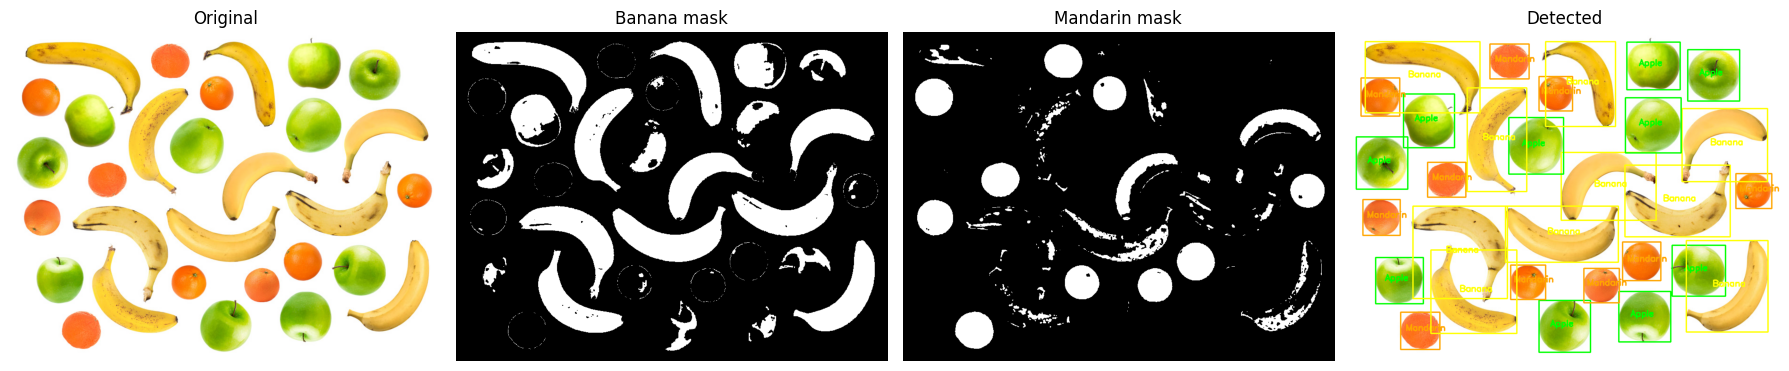

For COMP9517_25T3_Lab4_Images/Fruits2.jpg: Apples = 11, Bananas = 9, Mandarins = 12
Action: Remove 1 apples, Add 1 bananas, Remove 2 mandarins



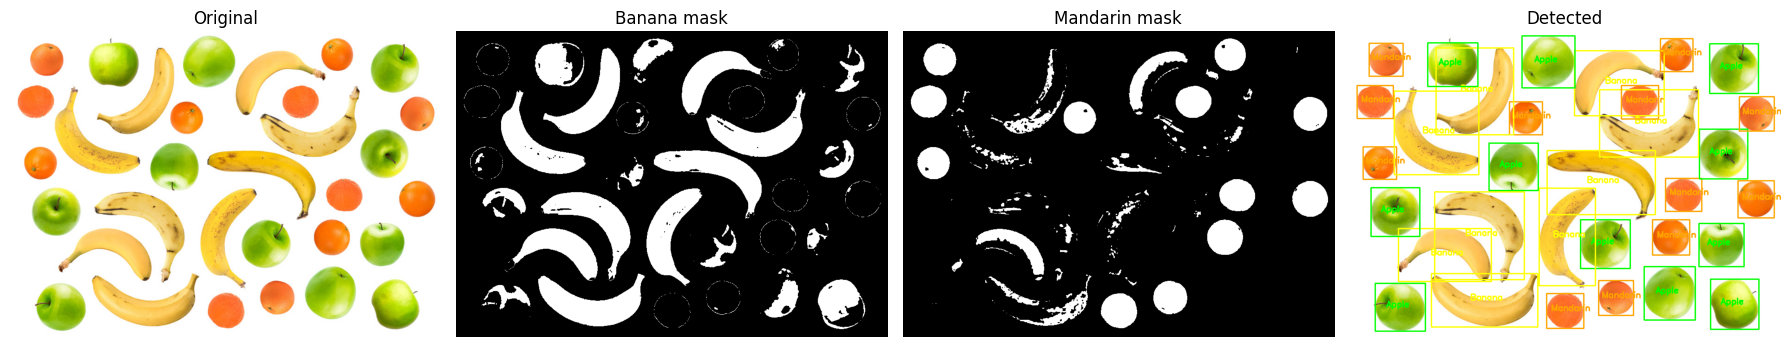

For COMP9517_25T3_Lab4_Images/Fruits3.jpg: Apples = 8, Bananas = 11, Mandarins = 9
Action: Add 2 apples, Remove 1 bananas, Add 1 mandarins



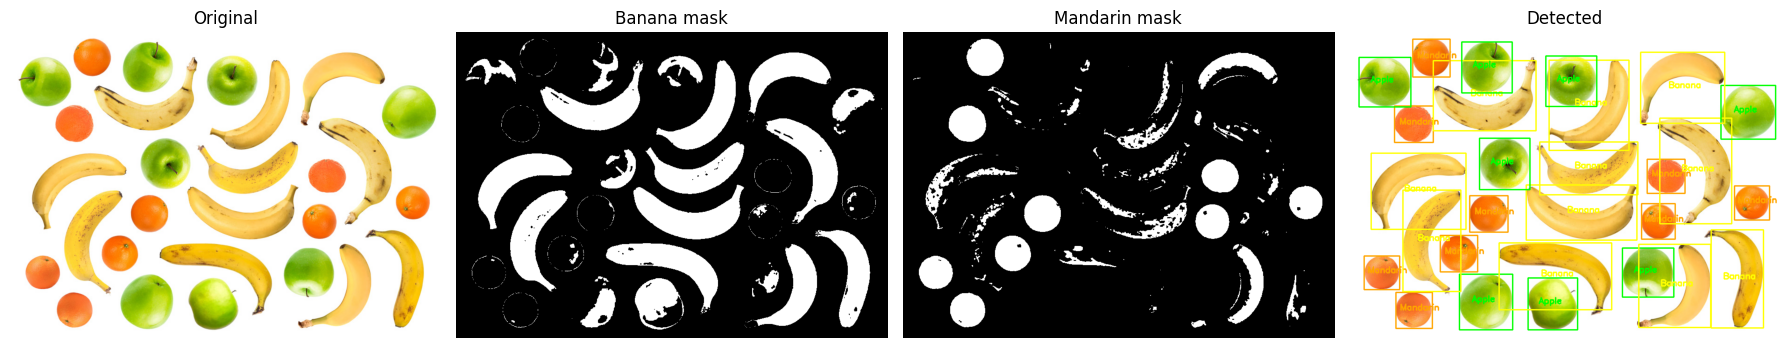

In [31]:
def circularity(area, perimeter):
    if perimeter == 0: return 0
    return 4 * math.pi * area / (perimeter * perimeter)

for path in image_paths:
    img = cv.imread(path)
    if img is None:
        print(f"Error loading {path}")
        continue

    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    hsv = cv.GaussianBlur(hsv, (5,5), 0)

    mask_banana = cv.inRange(hsv, banana_lower, banana_upper)
    mask_mandarin = cv.inRange(hsv, mandarin_lower, mandarin_upper)
    mask_apple = cv.inRange(hsv, apple_green_lower, apple_green_upper)

    combined = cv.bitwise_or(mask_banana, mask_mandarin)
    combined = cv.bitwise_or(combined, mask_apple)

    combined = cv.morphologyEx(combined, cv.MORPH_OPEN, kernel, iterations=1)
    combined = cv.morphologyEx(combined, cv.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv.findContours(combined, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    apples = bananas = mandarins = 0
    out = img.copy()

    for cnt in contours:
        area = cv.contourArea(cnt)
        if area < min_area:
            continue
        x, y, w, h = cv.boundingRect(cnt)
        comp_mask = np.zeros(combined.shape, dtype=np.uint8)
        cv.drawContours(comp_mask, [cnt], -1, 255, -1)

        overlap_b = cv.countNonZero(cv.bitwise_and(comp_mask, mask_banana))
        overlap_m = cv.countNonZero(cv.bitwise_and(comp_mask, mask_mandarin))
        overlap_a = cv.countNonZero(cv.bitwise_and(comp_mask, mask_apple))
        r_b = overlap_b / area
        r_m = overlap_m / area
        r_a = overlap_a / area

        perimeter = cv.arcLength(cnt, True)
        circ = circularity(area, perimeter)
        ecc = 0.0
        if len(cnt) >= 5:
            try:
                (cx, cy), (MA, ma), angle = cv.fitEllipse(cnt)
                major, minor = max(MA, ma), min(MA, ma)
                if major > 0:
                    ecc = math.sqrt(max(0.0, 1 - (minor / major) ** 2))
            except cv.error:
                ecc = 0.0

        fruit = None
        color_draw = (0,0,0)
        max_r = max(r_b, r_m, r_a)
        if max_r >= overlap_thresh:
            if r_b == max_r:
                fruit = "Banana"; color_draw = (0,255,255)
            elif r_m == max_r:
                fruit = "Mandarin"; color_draw = (0,165,255)
            else:
                fruit = "Apple"; color_draw = (0,255,0)
        else:
            if ecc > ecc_threshold and (r_b > 0.05 or circ < 0.45):
                fruit = "Banana"; color_draw = (0,255,255)
            elif circ >= circularity_threshold or r_a > r_m:
                fruit = "Apple"; color_draw = (0,255,0)
            else:
                fruit = "Mandarin"; color_draw = (0,165,255)

        cv.rectangle(out, (x,y), (x+w, y+h), color_draw, 2)
        cx = int(x + w/2); cy = int(y + h/2)
        cv.putText(out, fruit, (cx - 30, cy), cv.FONT_HERSHEY_SIMPLEX, 0.6, color_draw, 2)

        if fruit == "Banana": bananas += 1
        elif fruit == "Mandarin": mandarins += 1
        elif fruit == "Apple": apples += 1

    # Action instructions ===
    actions = []
    if apples < N:
        actions.append(f"Add {N - apples} apples")
    elif apples > N:
        actions.append(f"Remove {apples - N} apples")

    if bananas < N:
        actions.append(f"Add {N - bananas} bananas")
    elif bananas > N:
        actions.append(f"Remove {bananas - N} bananas")

    if mandarins < N:
        actions.append(f"Add {N - mandarins} mandarins")
    elif mandarins > N:
        actions.append(f"Remove {mandarins - N} mandarins")

    if not actions:
        result_msg = "All good"
    else:
        result_msg = ", ".join(actions)

    print(f"For {path}: Apples = {apples}, Bananas = {bananas}, Mandarins = {mandarins}")
    print(f"Action: {result_msg}\n")

    # Visualization
    fig, axs = plt.subplots(1,4, figsize=(18,5))
    axs[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)); axs[0].set_title("Original"); axs[0].axis('off')
    axs[1].imshow(mask_banana, cmap='gray'); axs[1].set_title("Banana mask"); axs[1].axis('off')
    axs[2].imshow(mask_mandarin, cmap='gray'); axs[2].set_title("Mandarin mask"); axs[2].axis('off')
    axs[3].imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB)); axs[3].set_title("Detected"); axs[3].axis('off')
    plt.tight_layout()
    plt.show()